In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# Define the start and end dates for fetching the stock data
start = '2012-01-01'  # Start date for data extraction
end = '2024-09-03'    # End date for data extraction

# Define the stock ticker symbol for Apple Inc.
stock = 'AAPL'        # 'AAPL' is the ticker symbol for Apple Inc. on NASDAQ

# Use the yfinance library to download historical stock data for Apple (AAPL)
# The 'download' method retrieves data between the specified start and end dates
data = yf.download(stock, start, end)

# Reset the index of the DataFrame so that the 'Date' column becomes a regular column
# This makes it easier to work with the data, especially for plotting and analysis
data.reset_index(inplace=True)

# Display the DataFrame containing historical stock data (Open, High, Low, Close, Volume, etc.)
data


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.402629,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.469282,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.607716,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.739512,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.719305,394024400
...,...,...,...,...,...,...,...
3181,2024-08-26,226.759995,227.279999,223.889999,227.179993,227.179993,30602200
3182,2024-08-27,226.000000,228.850006,224.889999,228.029999,228.029999,35934600
3183,2024-08-28,227.919998,229.860001,225.679993,226.490005,226.490005,38052200
3184,2024-08-29,230.100006,232.919998,228.880005,229.789993,229.789993,51906300


In [4]:
# Calculate the 100-day moving average for the 'Close' price of the stock
ma_100_days = data.Close.rolling(100).mean()

'''
The 100-day moving average is a common technical indicator 
used by traders and analysts to assess the overall trend direction over a medium-term period.
'''

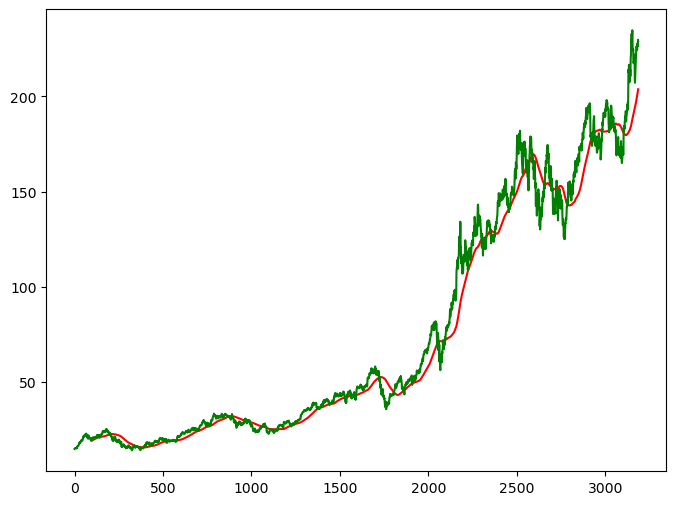

In [5]:
plt.figure(figsize=(8,6))  # Create a new figure with a specific size (8x6 inches)
plt.plot(ma_100_days, 'r')  # Plot the 100-day moving average in red ('r')
plt.plot(data.Close,'g')    # Plot the actual closing prices in green ('g')
plt.show()                  # Display the plot


In [6]:
# Calculate the 200-day moving average for the 'Close' price of the stock
ma_200_days = data.Close.rolling(200).mean()

'''
Significance of the 200-Day Moving Average:
It's often seen as a major indicator of a stock’s long-term trend.
A price consistently above the 200-day moving average is generally considered to be in a long-term uptrend, 
while a price consistently below it may indicate a long-term downtrend.
'''

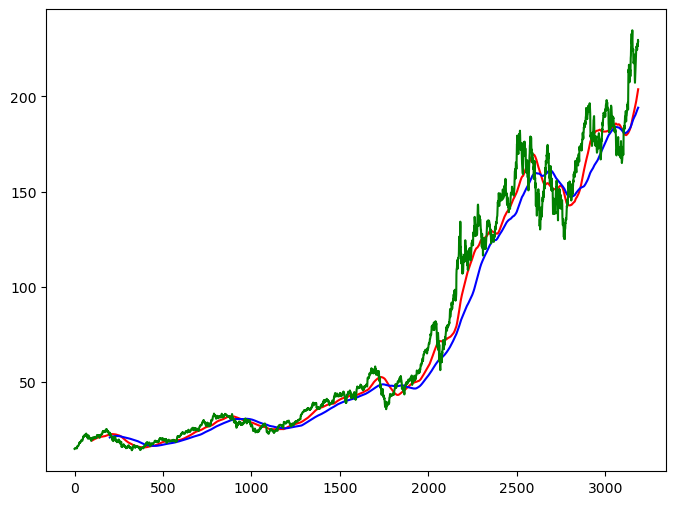

In [7]:
plt.figure(figsize=(8,6))

plt.plot(ma_100_days, 'r')

plt.plot(ma_200_days, 'b')

plt.plot(data.Close,'g')

plt.show()

In [8]:
data.dropna(inplace=True)

'''
When you calculate a rolling window (such as the 200-day moving average), 
the first N-1 rows (in this case, 199 rows) will contain NaN because there 
aren’t enough data points to compute the average. 
This results in missing values (NaN) at the start of the dataset.
'''

In [9]:
'''
 This selects the first 80% of the Close price data from the data DataFrame. 
 It essentially takes the data from index 0 to 80% of the total length of the dataset.
'''
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])

'''
 This selects the remaining 20% of the Close price data from 80% to the end of the dataset.
'''
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [10]:
'''
This will provide a tuple of two values:

The number of rows in the training set.
The number of rows in the testing set.
'''

data_train.shape[0], data_test.shape[0]

(2548, 638)

In [11]:
'''
    Machine Learning Models: 
        Many machine learning models, 
        especially those involving neural networks or distance-based 
        models like k-nearest neighbors, perform better when the input 
        features are on a similar scale. Scaling helps avoid the dominance 
        of large-valued features over small-valued ones.
    
    Stock Price Data: 
        Since stock prices can vary significantly, 
        scaling them ensures that the model treats all price ranges similarly, 
        making the training process more effective and stable.
'''

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
'''
    Many machine learning models require data to be scaled 
    so that the range of the features doesn't introduce bias or affect performance. 
    In this case, scaling the stock prices helps avoid issues related to different 
    magnitudes of values (e.g., smaller numbers like $10 versus larger numbers like $1000).

    Fit on Training Data: It's important to fit the scaler on the training data only to avoid data leakage 
                            (i.e., using information from the test set in the training process). 
                            This ensures that the model only learns patterns from the training data.
'''

data_train_scale = scaler.fit_transform(data_train)

In [13]:
x = [] # This will hold the input sequences, which consist of 100 consecutive time steps (e.g., closing prices) from the scaled data.
y = [] # This will hold the target values (also called labels) that correspond to the next time step (i.e., the closing price at the time step following the sequence).

'''
    The loop starts at index 100, because the first prediction will use the previous 100 time steps as inputs.
    data_train_scale.shape[0]: 
        This is the number of rows in the scaled training data, so the loop runs from 100 to the end of the dataset.
'''
for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i]) # For each i, the code appends the previous 100 time steps to the x list.
                                        # data_train_scale[i-100:i]: This selects a window of 100 consecutive data points ending at position i. 
                                        # These 100 points serve as the input features for the model.
    y.append(data_train_scale[i,0]) # For each i, the code appends the value at index i (the target value) to the y list.
                                    # data_train_scale[i, 0]: This grabs the next value in the time series (the 101st value in the sequence), 
                                    # which the model will try to predict based on the previous 100 values.

'''
    This format is necessary for models that work on sequential data because they learn 
    patterns from the sequence of past values to predict future values.
'''

In [14]:
x, y = np.array(x), np.array(y)

'''
    Efficient Processing: NumPy arrays are optimized for numerical operations 
    and are much faster than Python lists when it comes to large datasets.
    Compatibility: Many machine learning libraries (like Keras, TensorFlow, and PyTorch) 
    require input data to be in the form of arrays rather than lists.
'''

In [1]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

2024-09-06 09:50:39.467861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model = Sequential() # Sequential Model: This model allows stacking layers one by one. 
                     # The Sequential model is the most straightforward way to build a neural network in Keras.

'''
   units=50: This layer contains 50 LSTM units (neurons). Each unit helps the model learn long-term dependencies in the data.
   
   activation='relu': ReLU (Rectified Linear Unit) activation function introduces non-linearity into the network, helping the model capture complex relationships.
   
   return_sequences=True:  This means that the layer will return the entire sequence (not just the last output). Setting this to True is important when stacking multiple LSTM layers, 
                           as each LSTM layer needs the full sequence as input for the next layer.
    
    input_shape=(x.shape[1], 1): Specifies the shape of the input data. 
                                 The model expects input sequences of length x.shape[1] 
                                 (100 in your case) with 1 feature per timestep (the closing price).
   
'''
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
              input_shape = ((x.shape[1],1))))

'''
    Dropout(0.2): This layer randomly drops 20% of the neurons during each training step to prevent overfitting, 
    forcing the model to be more robust and not rely too much on any single neuron.

    How to choose specific activation functions?
'''
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

'''
    units=1: This is a fully connected layer with 1 output unit, 
             used for making the final prediction (in your case, likely the next stock price).
    There’s no activation function specified here, which means it uses the default linear activation. 
    This is common in regression tasks (e.g., predicting stock prices) where the output is a continuous value.
'''
model.add(Dense(units=1))

/Users/codymckeon/anaconda3/envs/Stock_Price_LSTM/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
model.fit(x,y, epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 0.0495
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0042
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 0.0044
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0041
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0038
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - loss: 0.0039
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 0.0034
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0030
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.0031
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0026
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 0.0030
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0026
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0025
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - loss: 0.0026
Epoch 15/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

In [47]:
past_100_days = data_train.tail(100)

In [54]:
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [56]:
data_test = pd.concat([past_100_days, data_test], ignore_index = True)

In [57]:
data_test

,Close
0,146.919998
1,145.369995
2,141.910004
3,142.830002
4,141.500000
...,...
733,227.179993
734,228.029999
735,226.490005
736,229.789993


In [58]:
data_test_scale = scaler.fit_transform(data_test)

In [59]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])

x, y = np.array(x), np.array(y)

In [60]:
y_predict = model.predict(x)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


In [61]:
y_predict

array([[0.4519022 ],
       [0.45634586],
       [0.45842063],
       [0.45810282],
       [0.4552731 ],
       [0.44970813],
       [0.44162792],
       [0.43171346],
       [0.4208348 ],
       [0.4097228 ],
       [0.3991794 ],
       [0.3898723 ],
       [0.38205814],
       [0.3754815 ],
       [0.36968595],
       [0.36455452],
       [0.35991234],
       [0.35547417],
       [0.35098302],
       [0.34632742],
       [0.34167403],
       [0.33734083],
       [0.33376908],
       [0.33145404],
       [0.3309852 ],
       [0.33289564],
       [0.33774   ],
       [0.34585398],
       [0.3573473 ],
       [0.37217015],
       [0.3898005 ],
       [0.40881556],
       [0.42732617],
       [0.44457054],
       [0.4598357 ],
       [0.47234708],
       [0.48180014],
       [0.48792034],
       [0.49001378],
       [0.48807198],
       [0.48277915],
       [0.47471714],
       [0.4644981 ],
       [0.45295745],
       [0.4409613 ],
       [0.42922735],
       [0.4179839 ],
       [0.407

In [62]:
scale= 1/scaler.scale_

In [63]:
y_predict = y_predict*scale

In [64]:
y=y*scale

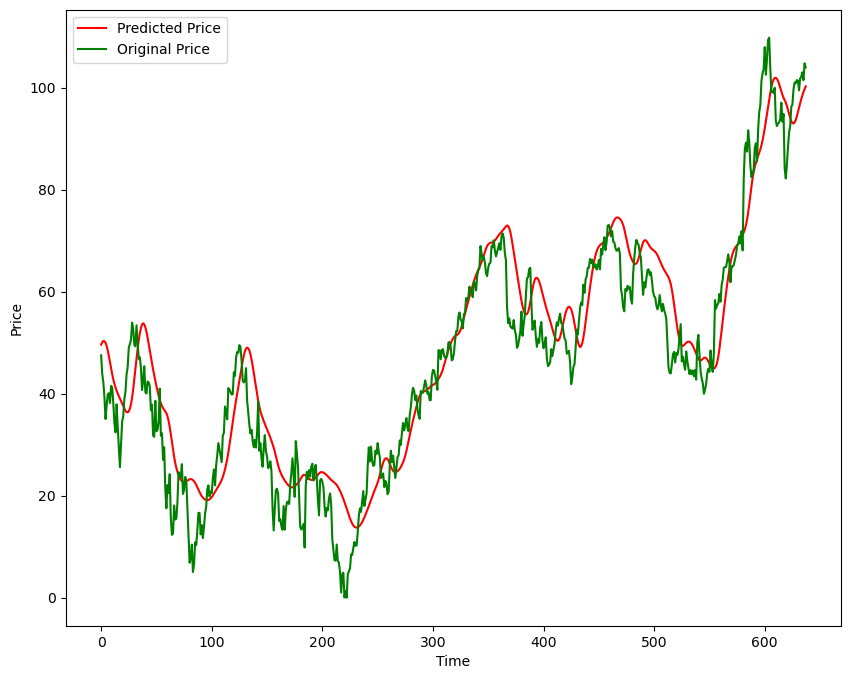

In [65]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [66]:
model.save('Stock Predictions Model.keras')